# A/B testing for Cookie Cats

## Load data and packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm
import statsmodels.stats.api as sms 
import hvplot.pandas
import hvplot.pandas
# from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
#     pearsonr, spearmanr, kendalltau, f_oneway, kruskal

In [2]:
df = pd.read_csv('cookie_cats.csv', encoding='utf-8')

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Data overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


检查有无缺失值

In [5]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [6]:
df['userid'].nunique()

90189

In [7]:
userid_count_version = df.groupby('version').agg({"userid":"count"}).reset_index()
userid_count_version

,version,userid
0,gate_30,44700
1,gate_40,45489


/var/folders/gk/b497571d49ndglvgyk5sb53h0000gn/T/ipykernel_71883/2235055055.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(userid_count_version, x ='version', y='userid', palette=colors)


<Axes: xlabel='version', ylabel='userid'>

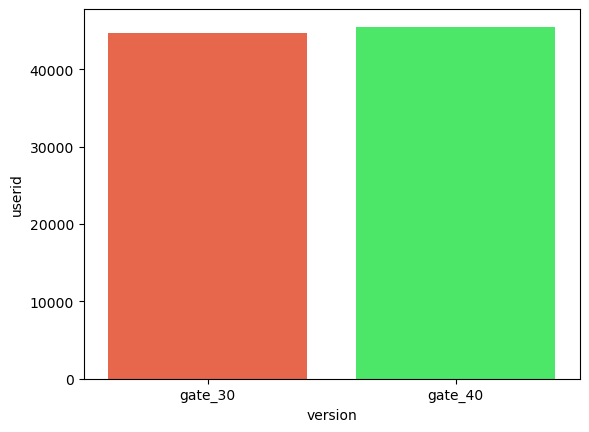

In [8]:
colors = ['#FF5733', '#33FF57']
sns.barplot(userid_count_version, x ='version', y='userid', palette=colors)

两组实验的次日留存率和方差

In [9]:
retention1_rates = df.groupby('version')['retention_1'].agg(['mean', 'std'])
retention1_rates

,mean,std
version,,
gate_30,0.448188,0.497314
gate_40,0.442283,0.496663


两组实验的7日留存率和方差

In [10]:
retention7_rates = df.groupby('version')['retention_7'].agg(['mean', 'std'])
retention7_rates

,mean,std
version,,
gate_30,0.190201,0.392464
gate_40,0.182000,0.385849


In [11]:
bins = [0, 25, 50, 75, 100, 10000, 30000]
df['sum_gamerounds_bins'] = pd.cut(df['sum_gamerounds'], bins=bins, labels=False)
df.groupby('version').sum_gamerounds_bins.value_counts().sort_values(ascending=False)

version  sum_gamerounds_bins
gate_40  0.0                    25491
gate_30  0.0                    24748
         1.0                     6879
gate_40  4.0                     6290
         1.0                     6265
gate_30  4.0                     6094
gate_40  2.0                     3401
gate_30  2.0                     3169
gate_40  3.0                     1985
gate_30  3.0                     1872
Name: count, dtype: int64

## 确定样本统计量和实验周期


每个组所需的最小样本量：

![样本统计量公式](images/最小样本量.png)

在这个公式当中， α为犯第一类错误的概率， β为犯第二类错误的概率，σ代表的是样本数据的标准差，δ代表的是预期实验组和对照组两组数据的差值。一般情况下，我们会设置：
* 显著性水平： α=0.05，即在拒绝原假设之前，我们有95%的把握新版落地页的转化率比旧版落地页要高
* 统计功效（1−β）： β=0.2，即表示测试检测特定效果的能力，如果该特定效果存在的话。在此案例中就是，如果新版落地页真的比旧版转换率要高，该测试有80%的概率能检测出这个状况。
* 指标比率的标准差计算公式：<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msup>
    <mi>&#x3C3;</mi>
    <mn>2</mn>
  </msup>
  <mo>=</mo>
  <msub>
    <mi>P</mi>
    <mi>A</mi>
  </msub>
  <mo stretchy="false">(</mo>
  <mn>1</mn>
  <mo>&#x2212;</mo>
  <msub>
    <mi>P</mi>
    <mi>A</mi>
  </msub>
  <mo stretchy="false">)</mo>
  <mo>+</mo>
  <msub>
    <mi>P</mi>
    <mi>B</mi>
  </msub>
  <mo stretchy="false">(</mo>
  <mn>1</mn>
  <mo>&#x2212;</mo>
  <msub>
    <mi>P</mi>
    <mi>B</mi>
  </msub>
  <mo stretchy="false">)</mo>
</math>

In [12]:
pa = retention7_rates.loc['gate_30', 'mean']
pb = retention7_rates.loc['gate_40', 'mean']
sigma2 = pa*(1-pa) + pb*(1-pb)
print("simga square is", sigma2)

simga square is 0.3029008196388529


1. 手算法

In [13]:
alpha = 0.05 # default should 0.05
beta = 0.2 # default should be 0.2 
z_1_half_alpha = norm.ppf(1-alpha/2)
z_1_beta = norm.ppf(1-beta)
mini_n = sigma2 * (z_1_half_alpha+z_1_beta)**2 / (pa-pb)**2
print("Minimun number of sample size for each group:", np.ceil(mini_n))

Minimun number of sample size for each group: 35347.0


2. package计算

In [14]:
effect_size = sms.proportion_effectsize(pa, pb)
required_n = sms.NormalIndPower().solve_power( 
    effect_size,  # 效应量
    power=0.8,    # 检验效能
    alpha=0.05,   # 显著性水平
    ratio=1 ,     # 样本比例
    ) # 计算所需的样本量
np.ceil(required_n)

35347.0

In [15]:
len(df[df['version']=='gate_30'])/2

22350.0

## AA testing

In [16]:
A1_index = df[df['version']=='gate_30'].sample(n=22350, random_state=1).index
A1_df = df.loc[A1_index]
gate30 = df[df['version']=='gate_30']
A2_df = gate30.loc[~gate30.index.isin(A1_index)]
len(A1_df), len(A2_df)

(22350, 22350)

In [17]:
n_AA = len(A1_df) 
A1_ret7, A2_ret7 = A1_df['retention_7'].sum(), A2_df['retention_7'].sum()
z_stat, pval = proportions_ztest([A1_ret7, A2_ret7], nobs=[n_AA, n_AA])
print("Test Stat = %.4f, p-value = %.4f" % (z_stat, pval))

Test Stat = 0.3857, p-value = 0.6998


由于p value = 0.69远高于显著水平0.05，所以AA实验保证数据波动很小，无异常。

## AB testing

### 1. 假设检验 

H0: µ1 = µ2      
H1: µ1 ≠ µ2 

总体均值检验
* 总体σ已知：z检验，z检验公式 z=(x̄-μ)/(σ/√n)
* 总体σ未知：
    * 样本容量小于30: t检验，t检验公式 t=(x̄-μ)/(S/√n)
    * 样本容量大于30: z检验，z检验公式 z=(x̄-μ)/(S/√n)

In [18]:
gate_30_ret1 = df.loc[df["version"] == "gate_30", "retention_1"]
gate_30_ret7 = df.loc[df["version"] == "gate_30", "retention_7"]

gate_40_ret1 = df.loc[df["version"] == "gate_40", "retention_1"]
gate_40_ret7 = df.loc[df["version"] == "gate_40", "retention_7"]

n_30, n_40 = len(gate_30_ret1), len(gate_40_ret1)
rentent1 = [gate_30_ret1.sum(), gate_40_ret1.sum()]
rentent7 = [gate_30_ret7.sum(), gate_40_ret7.sum()]
print(n_30, n_40, rentent1, rentent7)

44700 45489 [20034, 20119] [8502, 8279]


由于样本数大于30，使用z检验

In [19]:
z_stat, p_value = proportions_ztest(rentent1, nobs=[n_30, n_40])
(lower_gate30, lower_gate40), (upper_gate30, upper_gate40) = proportion_confint(rentent1, nobs=[n_30, n_40], alpha=0.05, method='normal')
print("次日留存率")
print("Test Stat = %.4f, p-value = %.4f" % (z_stat, p_value))
print(f"95% CI for gate_30: {lower_gate30:.4f} - {upper_gate30:.4f}")
print(f"95% CI for gate_40: {lower_gate40:.4f} - {upper_gate40:.4f}")

次日留存率
Test Stat = 1.7841, p-value = 0.0744
95% CI for gate_30: 0.4436 - 0.4528
95% CI for gate_40: 0.4377 - 0.4468


In [20]:
z_stat, p_value = proportions_ztest(rentent7, nobs=[n_30, n_40])
(lower_gate30, lower_gate40), (upper_gate30, upper_gate40) = proportion_confint(rentent7, nobs=[n_30, n_40], alpha=0.05, method='normal')
print("7日留存率")
print("Test Stat = %.4f, p-value = %.4f" % (z_stat, p_value))
print(f"95% CI for gate_30: {lower_gate30:.4f} - {upper_gate30:.4f}")
print(f"95% CI for gate_40: {lower_gate40:.4f} - {upper_gate40:.4f}")

7日留存率
Test Stat = 3.1644, p-value = 0.0016
95% CI for gate_30: 0.1866 - 0.1938
95% CI for gate_40: 0.1785 - 0.1855


### 2. 分析结果
由于计算出来的P值=0.0744高于显著水平，所以不能拒绝原假设H0，意味着广告插于在gate30和gate40之间对于次日留存率没有显著差异。

此外，从置信区间来看：
* 对于gate_30，次日留存率的置信区间为0.7441 - 0.8164，这意味着在95%的置信水平下，次日留存率的真实值在这两个值之间。
* 对于gate_40，次日留存率的置信区间为0.7318 - 0.8031，这意味着在95%的置信水平下，次日留存率的真实值在这两个值之间。



### 3. 结果不显著的后续建议
* 是否延长实验周期或直接推全
* 方差缩减，降低指标方差，提升T统计量，让指标更容易显著

### 方差缩减-分层分析

计算标准差公式

In [47]:
df[df['version']=='gate_30']['sum_gamerounds'].mean(), df[df['version']=='gate_40']['sum_gamerounds'].mean()

(52.45626398210291, 51.29877552814966)

In [21]:
def SE(p_mu, n1, n2):
    SE = np.sqrt(p_mu* (1-p_mu)*(1/n1+1/n2))
    return SE

In [22]:
def cal(n1, n2, SE_all, r1, r2):
    z_value = (rentent1[0]/n_30 - rentent1[1]/n_40)/SE_all
    print("z_value",z_value)
    p_value = norm.sf(abs(z_value))*2
    print("p_value",p_value)

没分层前的手算z检验统计量和p value过程，和之前答案一致

In [23]:
p_mu_all = retention1_rates['mean'].mean()
SE_all = SE(p_mu_all, n_30, n_40)
print("SE: ", SE_all)
cal(n_30, n_40, SE_all, rentent1[0], rentent1[1])

SE:  0.00330993173563522
z_value 1.784076004881163
p_value 0.07441131572314344


由于用户游玩次数具有长尾效应，按照分位数分箱

In [52]:
df['ground_bins'] = pd.qcut(df['sum_gamerounds'], q=3, labels=False)
var_list, prob_list = [], []
for group in df['ground_bins'].unique():
    gate_30_ret1 = df.loc[(df["version"] == "gate_30") & (df["ground_bins"] == group), "retention_1"]
    gate_40_ret1 = df.loc[(df["version"] == "gate_40") & (df["ground_bins"] == group), "retention_1"]
    p_mu_all = df.loc[df['ground_bins']==group]['retention_1'].mean()
    rentented = [gate_30_ret1.sum(), gate_40_ret1.sum()]
    n1, n2 = len(gate_30_ret1), len(gate_40_ret1)
    var_1 = p_mu_all* (1-p_mu_all)*(1/n1+1/n2)
    var_list.append(var_1)
    prob_list.append(len(df[df['ground_bins']==group])/len(df))
    print("Group: ", group, "Variance: ", var_1, "prob: ", len(df.loc[df['ground_bins']==group]['retention_1'])/len(df))
    # cal(n_30, n_40, SE_all, rentented[0], rentented[1])


Group:  0 Variance:  1.0805285356015739e-05 prob:  0.3572941267782102
Group:  2 Variance:  1.9844091814291296e-05 prob:  0.32792247391588775
Group:  1 Variance:  3.486412793671012e-05 prob:  0.31478339930590205


In [53]:
SE_stat = np.sqrt(np.sum(np.multiply(var_list, np.array(prob_list)**2)))
print("SE: ", SE_stat)
cal(n_30, n_40, SE_stat, rentent1[0], rentent1[1])

SE:  0.0026396832829149457
z_value 2.2370751163830933
p_value 0.025281430997389758


由于p value小于0.05，说明除去组间方差后，次日留存率结果显著

### 方差缩减
用CUPED的方法，消除corr(X,Y)的影响，得到新的Y_cuped

var(Y_cuped) = var(Y) + theta^2 * var(X) - 2theta*cov(X,Y)
只有当theta= cov(Y,X)/var(X)时，var(Y_cuped)最小

In [68]:
var_30 = retention1_rates.loc['gate_30']['std']**2
var_40 = retention1_rates.loc['gate_40']['std']**2

num_df = df[['retention_1','sum_gamerounds']]
corr=num_df.corr()['sum_gamerounds']['retention_1']
print(var_30, var_40, corr)

0.247321041219637 0.2466741417357029 0.19760286439906047


In [74]:
var_cuped = (SE_all**2)*(1-corr**2)
print("SE in cuped: ", np.sqrt(var_cuped))
cal(n_30, n_40, np.sqrt(var_cuped), rentent1[0], rentent1[1])

SE in cuped:  0.0032446670224264415
z_value 1.8199617238151689
p_value 0.06876483404284857


In [118]:
num_df = df[['dum_ret7','sum_gamerounds']]
theta = num_df.cov()['sum_gamerounds']['dum_ret7']/num_df.cov()['sum_gamerounds']['sum_gamerounds']
df['y_cuped'] = df.dum_ret7 - theta * df.sum_gamerounds

In [124]:
gate_30_ret1 = df.loc[df["version"] == "gate_30", "y_cuped"]
gate_40_ret1 = df.loc[df["version"] == "gate_40", "y_cuped"]

n_30, n_40 = len(gate_30_ret1), len(gate_40_ret1)
rentent1 = [gate_30_ret1.sum(), gate_40_ret1.sum()]
rentent7 = [gate_30_ret7.sum(), gate_40_ret7.sum()]
print(n_30, n_40, rentent1, rentent7)

z_stat, p_value = proportions_ztest(rentent1, nobs=[n_30, n_40])
(lower_gate30, lower_gate40), (upper_gate30, upper_gate40) = proportion_confint(rentent1, nobs=[n_30, n_40], alpha=0.05, method='normal')
print("次日留存率")
print("Test Stat = %.4f, p-value = %.4f" % (z_stat, p_value))
print(f"95% CI for gate_30: {lower_gate30:.4f} - {upper_gate30:.4f}")
print(f"95% CI for gate_40: {lower_gate40:.4f} - {upper_gate40:.4f}")